#**KLASIFIKASI GENRE MUSIK MENGGUNAKAN ALGORITMA CNN DAN EKSTRASI FITUR MFCC**

##Install & Import Library

In [ ]:
# Install necessary packages
!pip install librosa

# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import math
import librosa
import IPython.display as ipd
import librosa.display
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
import sklearn.model_selection as sk
from sklearn.model_selection import train_test_split, KFold

##Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


##File Collection

In [ ]:
from collections import Counter
MUSIC = '/content/drive/MyDrive/Colab Notebooks/KLASIFIKASI MUSIC PPDM/DATASET/genres_original/'
music_dataset = [] # File locations for each wav file
genre_target = [] #
for root, dirs, files in os.walk(MUSIC):
    for name in files:
        filename = os.path.join(root, name)
        if filename != '../DATASET/genres_original/jazz/jazz.00054.wav':
            music_dataset.append(filename)
            genre_target.append(filename.split("/")[8])  # Sesuaikan indeks ini

In [ ]:
# Menghitung jumlah genre dan jumlah file dalam setiap genre
genre_counts = Counter(genre_target)

# Menampilkan jumlah genre
print(f"Number of genres: {len(genre_counts)}")

# Menampilkan jumlah file dalam setiap genre
for genre, count in genre_counts.items():
    print(f"{genre}: {count} files")

Number of genres: 10
rock: 100 files
country: 100 files
hiphop: 100 files
classical: 100 files
disco: 100 files
metal: 100 files
pop: 100 files
blues: 100 files
jazz: 100 files
reggae: 100 files


### Testing Audio Files

In [ ]:
audio_path = music_dataset[500]

x , sr = librosa.load(audio_path)



librosa.load(audio_path, sr=None)

ipd.Audio(audio_path)

## Visualizing Audio

###Waveform

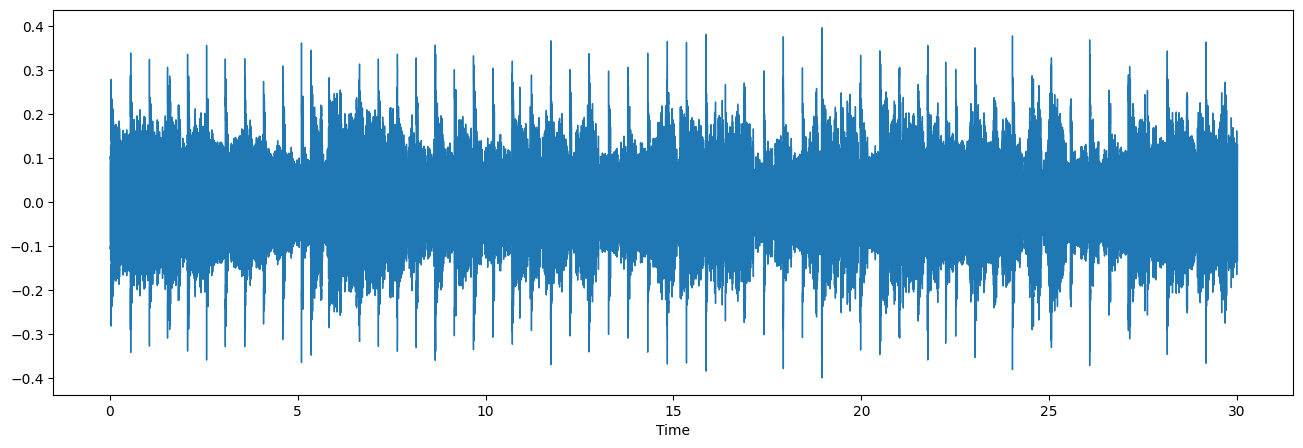

In [ ]:
plt.figure(figsize=(16, 5))
librosa.display.waveshow(x, sr=sr)

###Spectogram

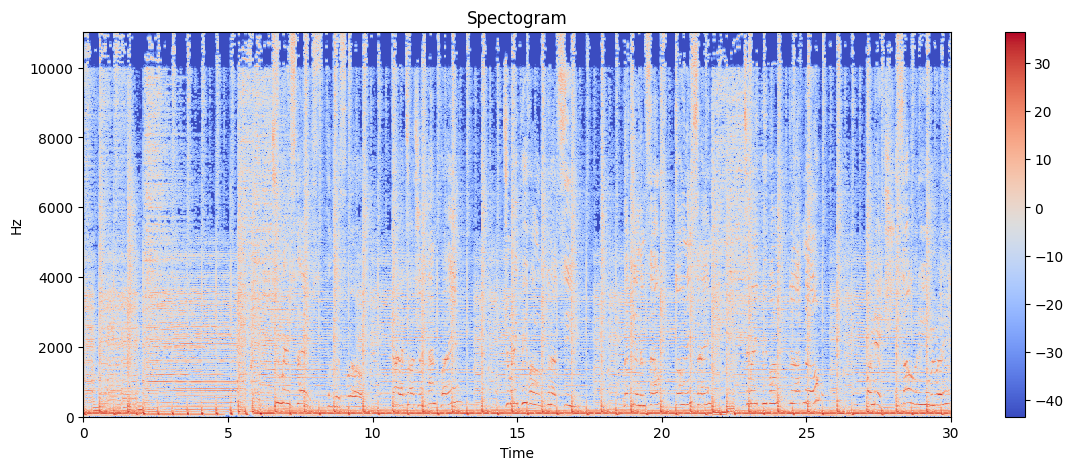

In [ ]:

X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.title('Spectogram')
plt.colorbar()



###Mel-Spectogram

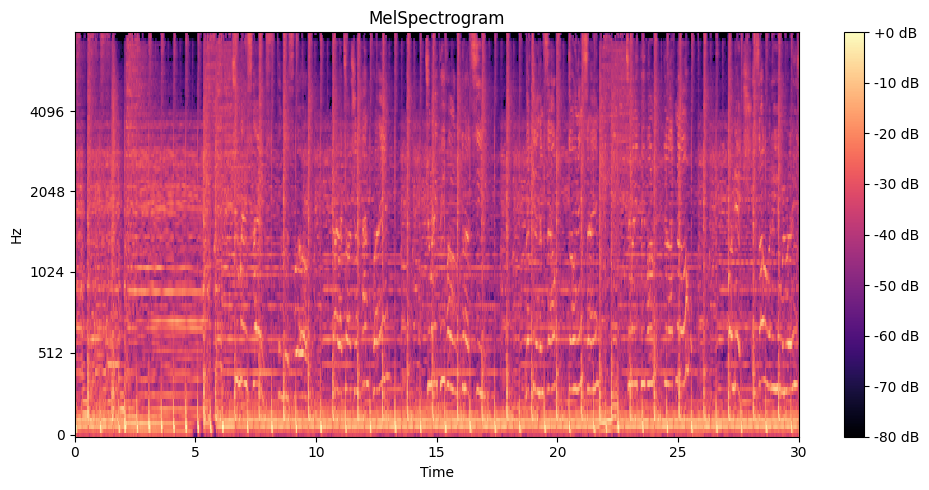

In [ ]:


file_location = audio_path
y, sr = librosa.load(file_location)
melSpec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
melSpec_dB = librosa.power_to_db(melSpec, ref=np.max)
plt.figure(figsize=(10, 5))
librosa.display.specshow(melSpec_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
plt.colorbar(format='%+1.0f dB')
plt.title("MelSpectrogram")
plt.tight_layout()
plt.show()


##Ekstraksi MFCC & Save as JSON

In [ ]:
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/KLASIFIKASI MUSIC PPDM/DATASET/genres_original/'
JSON_PATH = "/content/drive/MyDrive/Colab Notebooks/KLASIFIKASI MUSIC PPDM/data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30  # diukur dalam detik
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

def save_mfcc(DATASET_PATH, JSON_PATH, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Mengekstraksi MFCC dari dataset musik dan menyimpannya ke dalam file JSON bersama dengan label genre.

    :param dataset_path (str): Jalur menuju dataset
    :param json_path (str): Jalur menuju file JSON yang digunakan untuk menyimpan MFCC
    :param num_mfcc (int): Jumlah koefisien yang akan diekstraksi
    :param n_fft (int): Interval yang dipertimbangkan untuk menerapkan FFT. Diukur dalam jumlah sampel
    :param hop_length (int): Jendela geser untuk FFT. Diukur dalam jumlah sampel
    :param num_segments (int): Jumlah segmen yang ingin dibagi dari setiap track sampel
    :return:
    """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(DATASET_PATH)):

        # ensure we're processing a genre sub-folder level
        if dirpath != DATASET_PATH:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

                # load audio file
                file_path = os.path.join(dirpath, f)

                if file_path != '/content/drive/MyDrive/Colab Notebooks/KLASIFIKASI MUSIC PPDM/DATASET/genres_original/jazz/jazz.00054.wav':
                    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                    # process all segments of audio file
                    for d in range(num_segments):

                        # calculate start and finish sample for current segment
                        start = samples_per_segment * d
                        finish = start + samples_per_segment

                        # extract mfcc
                        mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                        mfcc = mfcc.T

                        # store only mfcc feature with expected number of vectors
                        if len(mfcc) == num_mfcc_vectors_per_segment:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                            print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(JSON_PATH, "w") as fp:
        json.dump(data, fp, indent=4)



In [ ]:
# Runs Data Processing
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=6)

Output streaming akan dipotong hingga 5000 baris terakhir.
/content/drive/MyDrive/Colab Notebooks/KLASIFIKASI MUSIC PPDM/DATASET/genres_original/country/country.00074.wav, segment:2
/content/drive/MyDrive/Colab Notebooks/KLASIFIKASI MUSIC PPDM/DATASET/genres_original/country/country.00074.wav, segment:3
/content/drive/MyDrive/Colab Notebooks/KLASIFIKASI MUSIC PPDM/DATASET/genres_original/country/country.00074.wav, segment:4
/content/drive/MyDrive/Colab Notebooks/KLASIFIKASI MUSIC PPDM/DATASET/genres_original/country/country.00074.wav, segment:5
/content/drive/MyDrive/Colab Notebooks/KLASIFIKASI MUSIC PPDM/DATASET/genres_original/country/country.00074.wav, segment:6
/content/drive/MyDrive/Colab Notebooks/KLASIFIKASI MUSIC PPDM/DATASET/genres_original/country/country.00076.wav, segment:1
/content/drive/MyDrive/Colab Notebooks/KLASIFIKASI MUSIC PPDM/DATASET/genres_original/country/country.00076.wav, segment:2
/content/drive/MyDrive/Colab Notebooks/KLASIFIKASI MUSIC PPDM/DATASET/genres_ori

##Pemrosesan Data & Pembangunan Model

In [ ]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/KLASIFIKASI MUSIC PPDM/data_10.json"

def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    z = np.array(data['mapping'])
    return X, y, z

def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

def prepare_datasets_kfold(n_splits=5):
    """Load data and prepare K-Fold Cross Validation datasets
    :param n_splits (int): Number of folds
    :return: List of tuples containing (train_index, test_index) for each fold
    """
    X, y, z = load_data(DATA_PATH)
    X = X[..., np.newaxis]
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    return list(kfold.split(X, y)), X, y, z

def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    # get mappings for target and predicted label
    target = z[y]
    predicted = z[predicted_index]

    print("Target: {}, Predicted label: {}".format(target, predicted))


##Pelatihan Model dengan K-Fold Cross Validation

Epoch 1/50
150/150 [==============================] - 18s 111ms/step - loss: 2.3928 - accuracy: 0.2518 - val_loss: 2.0639 - val_accuracy: 0.2711
Epoch 2/50
150/150 [==============================] - 16s 108ms/step - loss: 1.9126 - accuracy: 0.3724 - val_loss: 1.7169 - val_accuracy: 0.3862
Epoch 3/50
150/150 [==============================] - 16s 108ms/step - loss: 1.6785 - accuracy: 0.4317 - val_loss: 1.5519 - val_accuracy: 0.4412
Epoch 4/50
150/150 [==============================] - 16s 108ms/step - loss: 1.5283 - accuracy: 0.4623 - val_loss: 1.4623 - val_accuracy: 0.4729
Epoch 5/50
150/150 [==============================] - 16s 108ms/step - loss: 1.4222 - accuracy: 0.4926 - val_loss: 1.3927 - val_accuracy: 0.4946
Epoch 6/50
150/150 [==============================] - 17s 111ms/step - loss: 1.3344 - accuracy: 0.5281 - val_loss: 1.3233 - val_accuracy: 0.5146
Epoch 7/50
150/150 [==============================] - 16s 107ms/step - loss: 1.2766 - accuracy: 0.5546 - val_loss: 1.2793 - val_ac

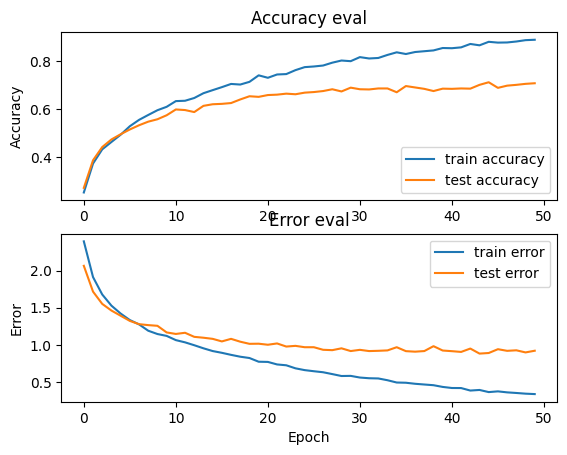

Epoch 1/50
150/150 [==============================] - 18s 112ms/step - loss: 2.4156 - accuracy: 0.2132 - val_loss: 1.8919 - val_accuracy: 0.3269
Epoch 2/50
150/150 [==============================] - 17s 111ms/step - loss: 1.8221 - accuracy: 0.3651 - val_loss: 1.4683 - val_accuracy: 0.4662
Epoch 3/50
150/150 [==============================] - 16s 109ms/step - loss: 1.6393 - accuracy: 0.4160 - val_loss: 1.3673 - val_accuracy: 0.5146
Epoch 4/50
150/150 [==============================] - 16s 107ms/step - loss: 1.5027 - accuracy: 0.4653 - val_loss: 1.2578 - val_accuracy: 0.5488
Epoch 5/50
150/150 [==============================] - 16s 106ms/step - loss: 1.4249 - accuracy: 0.4945 - val_loss: 1.1947 - val_accuracy: 0.5696
Epoch 6/50
150/150 [==============================] - 16s 106ms/step - loss: 1.3332 - accuracy: 0.5199 - val_loss: 1.1347 - val_accuracy: 0.5997
Epoch 7/50
150/150 [==============================] - 16s 105ms/step - loss: 1.2577 - accuracy: 0.5564 - val_loss: 1.1066 - val_ac

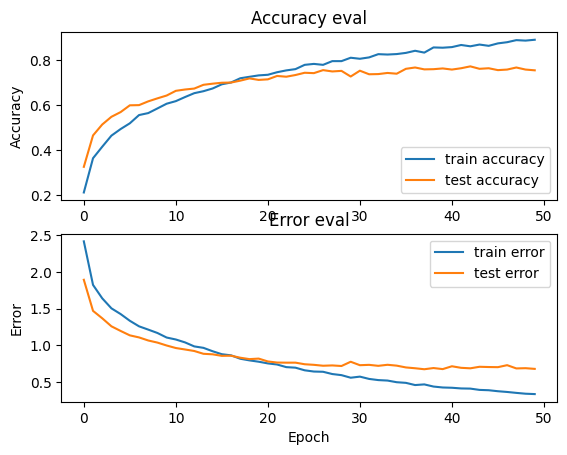

Epoch 1/50
150/150 [==============================] - 19s 110ms/step - loss: 2.4880 - accuracy: 0.2345 - val_loss: 1.8462 - val_accuracy: 0.3673
Epoch 2/50
150/150 [==============================] - 16s 106ms/step - loss: 1.8262 - accuracy: 0.3844 - val_loss: 1.4770 - val_accuracy: 0.4674
Epoch 3/50
150/150 [==============================] - 17s 111ms/step - loss: 1.6062 - accuracy: 0.4364 - val_loss: 1.3252 - val_accuracy: 0.5275
Epoch 4/50
150/150 [==============================] - 17s 110ms/step - loss: 1.4726 - accuracy: 0.4758 - val_loss: 1.2620 - val_accuracy: 0.5526
Epoch 5/50
150/150 [==============================] - 16s 107ms/step - loss: 1.3726 - accuracy: 0.5127 - val_loss: 1.1847 - val_accuracy: 0.5743
Epoch 6/50
150/150 [==============================] - 17s 111ms/step - loss: 1.2956 - accuracy: 0.5430 - val_loss: 1.1575 - val_accuracy: 0.5960
Epoch 7/50
150/150 [==============================] - 17s 111ms/step - loss: 1.2274 - accuracy: 0.5622 - val_loss: 1.1202 - val_ac

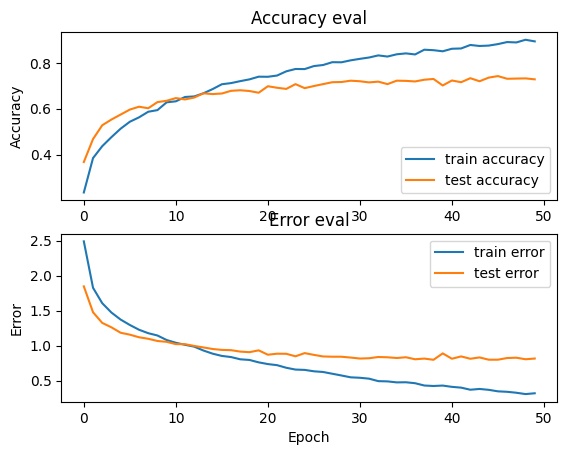

Epoch 1/50
150/150 [==============================] - 19s 114ms/step - loss: 2.3326 - accuracy: 0.2509 - val_loss: 1.9672 - val_accuracy: 0.2997
Epoch 2/50
150/150 [==============================] - 16s 110ms/step - loss: 1.7967 - accuracy: 0.3690 - val_loss: 1.5728 - val_accuracy: 0.4290
Epoch 3/50
150/150 [==============================] - 17s 110ms/step - loss: 1.5757 - accuracy: 0.4380 - val_loss: 1.3928 - val_accuracy: 0.5050
Epoch 4/50
150/150 [==============================] - 16s 106ms/step - loss: 1.4297 - accuracy: 0.4931 - val_loss: 1.3297 - val_accuracy: 0.5167
Epoch 5/50
150/150 [==============================] - 20s 134ms/step - loss: 1.3347 - accuracy: 0.5223 - val_loss: 1.2539 - val_accuracy: 0.5551
Epoch 6/50
150/150 [==============================] - 16s 109ms/step - loss: 1.2535 - accuracy: 0.5480 - val_loss: 1.1895 - val_accuracy: 0.5851
Epoch 7/50
150/150 [==============================] - 16s 109ms/step - loss: 1.1902 - accuracy: 0.5622 - val_loss: 1.1640 - val_ac

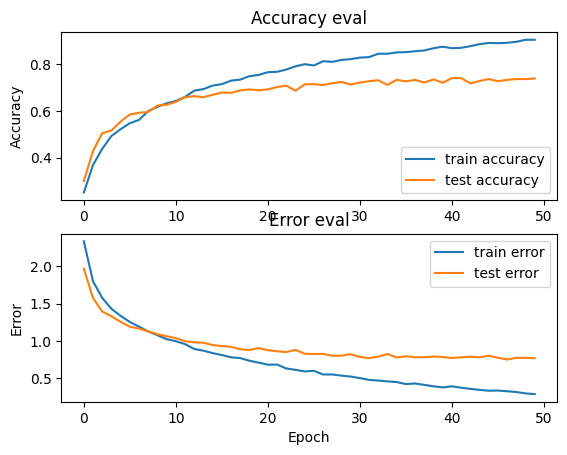

Epoch 1/50
150/150 [==============================] - 19s 112ms/step - loss: 2.3808 - accuracy: 0.2530 - val_loss: 1.7667 - val_accuracy: 0.3623
Epoch 2/50
150/150 [==============================] - 16s 110ms/step - loss: 1.8099 - accuracy: 0.3780 - val_loss: 1.4641 - val_accuracy: 0.4750
Epoch 3/50
150/150 [==============================] - 16s 110ms/step - loss: 1.6070 - accuracy: 0.4274 - val_loss: 1.3339 - val_accuracy: 0.5250
Epoch 4/50
150/150 [==============================] - 17s 112ms/step - loss: 1.5036 - accuracy: 0.4539 - val_loss: 1.2683 - val_accuracy: 0.5409
Epoch 5/50
150/150 [==============================] - 16s 109ms/step - loss: 1.3739 - accuracy: 0.5027 - val_loss: 1.1892 - val_accuracy: 0.5726
Epoch 6/50
150/150 [==============================] - 17s 111ms/step - loss: 1.3271 - accuracy: 0.5094 - val_loss: 1.1400 - val_accuracy: 0.5918
Epoch 7/50
150/150 [==============================] - 16s 109ms/step - loss: 1.2387 - accuracy: 0.5524 - val_loss: 1.1107 - val_ac

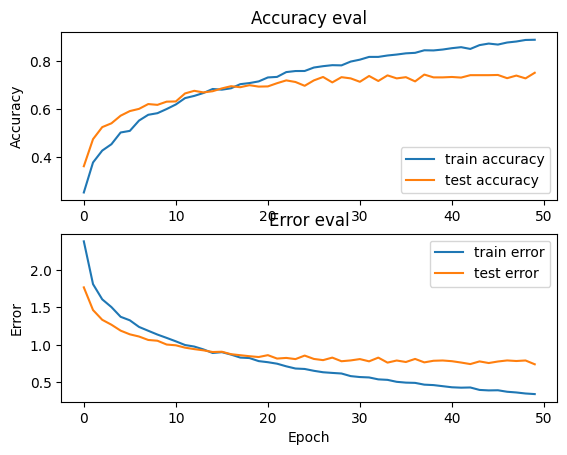

Average Test accuracy across all folds: 0.7361499190330505


In [ ]:

# prepare k-fold cross validation datasets
kfold_splits, X, y, z = prepare_datasets_kfold(n_splits=5)

# initialize variables to store cumulative metrics
cumulative_accuracy = 0

# loop through each fold
for train_index, test_index in kfold_splits:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=50, verbose=1)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    cumulative_accuracy += test_acc

    # plot accuracy/error for training and validation for each fold
    plot_history(history)

# calculate average accuracy
average_accuracy = cumulative_accuracy / len(kfold_splits)
print('Average Test accuracy across all folds:', average_accuracy)

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/KLASIFIKASI MUSIC PPDM/music_genre_classification_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##Evaluasi Model

In [ ]:
# Load the model using pickle
model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/KLASIFIKASI MUSIC PPDM/music_genre_classification_model.h5")

38/38 [==============================] - 1s 20ms/step


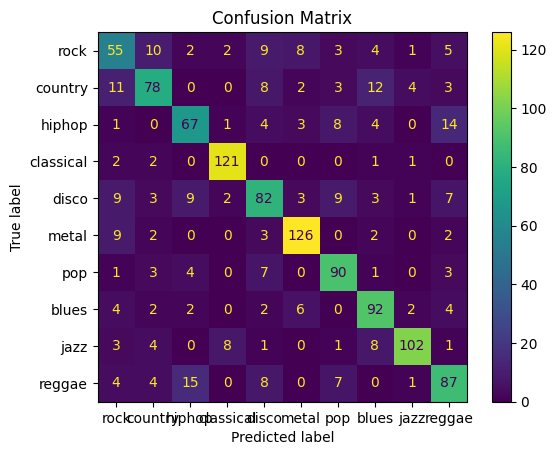

Classification Report
              precision    recall  f1-score   support

        rock       0.56      0.56      0.56        99
     country       0.72      0.64      0.68       121
      hiphop       0.68      0.66      0.67       102
   classical       0.90      0.95      0.93       127
       disco       0.66      0.64      0.65       128
       metal       0.85      0.88      0.86       144
         pop       0.74      0.83      0.78       109
       blues       0.72      0.81      0.76       114
        jazz       0.91      0.80      0.85       128
      reggae       0.69      0.69      0.69       126

    accuracy                           0.75      1198
   macro avg       0.74      0.74      0.74      1198
weighted avg       0.75      0.75      0.75      1198



In [ ]:
# Menampilkan Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Membuat prediksi pada seluruh data uji
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Menampilkan confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
cmd = ConfusionMatrixDisplay(cm, display_labels=z)
cmd.plot()
plt.title('Confusion Matrix')
plt.show()

# Menampilkan Classification Report
from sklearn.metrics import classification_report

print("Classification Report")
print(classification_report(y_test, y_pred_classes, target_names=z))

##Visualisasi Akurasi dan Error

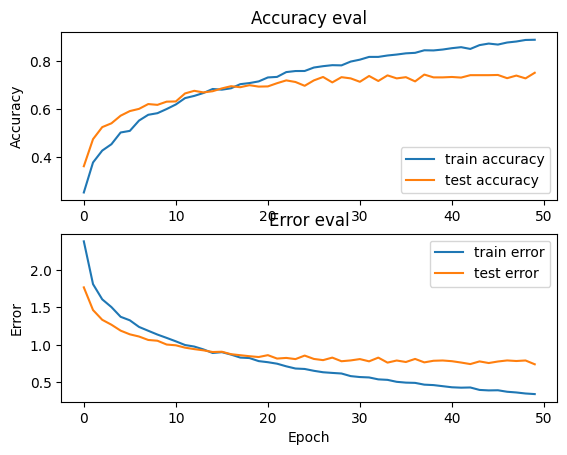

38/38 - 1s - loss: 0.7403 - accuracy: 0.7513 - 902ms/epoch - 24ms/step

Test accuracy: 0.7512521147727966


In [ ]:
# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

##Prediksi Sampel dari Data Pengujian

In [ ]:
# pick a sample to predict from the test set
X_to_predict = X_test[350]
y_to_predict = y_test[350]

# predict sample
predict(model, X_to_predict, y_to_predict)

1/1 [==============================] - 0s 33ms/step
Target: classical, Predicted label: ['classical']
